- 

- https://www.cia.gov/the-world-factbook/references/guide-to-country-comparisons/

- https://www.cia.gov/the-world-factbook/field/exports-partners/


# International Trade Network Analysis: Understanding Global Economic Interactions

International trade forms the backbone of the global economy, facilitating the exchange of goods, services, and resources between countries. The intricate web of trade relationships not only impacts national economies but also influences global economic stability and growth. Understanding these relationships is crucial for policymakers, economists, and business leaders alike. In this context, network analysis provides a powerful tool to unravel the complexities of international trade.

International trade networks are dynamic and complex. By analyzing these networks, we can uncover patterns, trends, and key players that shape global trade. Through centrality measures we can identify countries that play a central role in the trade network. These central countries often act as major hubs, influencing trade flows and economic policies.

In [1]:
from utils_single_2 import *

In [2]:
with open('countries.json', 'r') as file:
    data = json.load(file)

Probably due to the apostrophe, the scraping for Cote d'Ivoire fails, and there is no entry in the dataset, although the country being mentioned as an Import and Export partner by several countries, hence we insert the country manually taking its data from its [dataset web-page](https://www.cia.gov/the-world-factbook/countries/cote-divoire/summaries).

In [3]:
data['Cote d\'Ivoire'] = {
    "Economy: Real GDP (purchasing power parity)": "$202.758 billion (2023 est.)$190.319 billion (2022 est.)$179.178 billion (2021 est.)",
    "Economy: GDP - composition, by end use - exports of goods and services": "30.8%",
    "Economy: GDP - composition, by end use - imports of goods and services": "-30.1% (2017 est.)",
    "Economy: Exports": "$17.211 billion (2022 est.)$16.23 billion (2021 est.)$13.232 billion (2020 est.)",
    "Economy: Exports - partners": "Switzerland 9%, Mali 8%, Netherlands 8%, US 6%, France 5% (2022)",
    "Economy: Exports - commodities": "cocoa beans, gold, rubber, refined petroleum, cocoa paste (2022)",
    "Economy: Imports": "$19.948 billion (2022 est.)$16.191 billion (2021 est.)$12.66 billion (2020 est.)",
    "Economy: Imports - partners": "China 18%, Nigeria 11%, France 8%, India 5%, Belgium 4% (2022)",
    "Economy: Imports - commodities": "crude petroleum, refined petroleum, ships, rice, fish (2022)",
    "Geography: Geographic coordinates": "8 00 N, 5 00 W",
    "Government: Government type": "presidential republic"
}

To be fair, there were some other countries missing: Guadeloupe, Martinique, Mayotte, Reunion and French Guiana.

From the official The World Factbook [FAQs]():

> **Why has The World Factbook dropped the five French departments of Guadeloupe, Martinique, Mayotte, Reunion, and French Guiana?**
> The five entities are no longer in the World Factbook because their status has changed. While they are overseas departments of France, they are also now recognized as French regions, having equal status to the 22 metropolitan regions that make up European France. In other words, they are now recognized as being part of France proper. Their status is somewhat analogous to Alaska and Hawaii vis-à-vis the contiguous United States. Although separated from the larger geographic entity, they are still considered to be an integral part of it.

# 1. Network Creation
## Data Preprocessing

In [4]:
old_keys = list(key_mapping.keys())

# Filter the data
filtered_data = {}
missing_data = []

for country, info in data.items():
    # Check if the country is France and adjust the key accordingly
    if country == 'France':
        required_keys = set(old_keys)
        required_keys.remove("Geography: Geographic coordinates")
        required_keys.add("Geography: Geographic coordinates - metropolitan France")
    else:
        required_keys = set(old_keys)

    # Check if all required keys are present
    if required_keys <= set(info.keys()):
        filtered_data[country] = info
    else:
        missing_data.append(country)

data = filtered_data

print("\nCountries missing required data:")
print("\n".join('\t' + country for country in missing_data))


Countries missing required data:
	Akrotiri
	Andorra
	Anguilla
	Antarctica
	Ashmore and Cartier Islands
	Baker Island
	Bouvet Island
	British Indian Ocean Territory
	Christmas Island
	Clipperton Island
	Cocos (Keeling) Islands
	Cook Islands
	Coral Sea Islands
	Dhekelia
	Falkland Islands (Islas Malvinas)
	Faroe Islands
	French Southern and Antarctic Lands
	Gaza Strip
	Gibraltar
	Guernsey
	Heard Island and McDonald Islands
	Holy See (Vatican City)
	Howland Island
	Isle of Man
	Jan Mayen
	Jarvis Island
	Jersey
	Johnston Atoll
	Kingman Reef
	Kiribati
	Liechtenstein
	Midway Islands
	Monaco
	Navassa Island
	Niue
	Norfolk Island
	Palmyra Atoll
	Paracel Islands
	Pitcairn Islands
	Saint Barthelemy
	Saint Helena, Ascension, and Tristan da Cunha
	Saint Martin
	Saint Pierre and Miquelon
	Sint Maarten
	Spratly Islands
	Svalbard
	Tokelau
	Wake Island
	Wallis and Futuna
	West Bank
	World


In [5]:
# Loop over each country and its associated data in the 'data' dictionary.
for country, country_data in data.items():
    # Adjust the keys specifically for France
    updated_country_data = {}
    for key, value in country_data.items():
        if country == "France" and key == "Geography: Geographic coordinates - metropolitan France":
            updated_country_data["Coordinates"] = value
        elif key in old_keys:
            new_key = key_mapping.get(key, key)
            updated_country_data[new_key] = value
    
    data[country] = updated_country_data

In [6]:
# Loop over each country's data to clean up percentage values by removing '%' and any text after a space and parentheses.
for country_data in data.values():
    for key, value in country_data.items():
        # Extract the part of the value before the first occurrence of ' (' and remove the '%' sign.
        tempval = value.split(' (')[0]
        # Update the value in the dictionary after stripping the '%' sign.
        country_data[key] = tempval.strip('%')

In [7]:
# Loop over each country's data to process export and import partners.
for country_data in data.values():
    # Process the 'Export Partners' string, splitting it into individual partner entries.
    export_partners_str = country_data['Export Partners']
    export_partners = export_partners_str.split(', ')

    # Create a new dictionary to hold the export partners and their associated percentages.
    export_partner_associations = {}

    # Loop over each partner string to separate the partner's name and the percentage.
    for partner_str in export_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]  # Extract the partner's name.
        percentage = partner_str[last_space_index+1:]  # Extract the percentage.
        percentage = percentage.replace(',', '')  # Remove commas from the percentage.
        percentage = percentage.replace('%', '')  # Remove the '%' sign.

        # Add the partner and percentage to the 'export_partner_associations' dictionary.
        export_partner_associations[partner] = percentage

    # Update the 'Export Partners' entry in the country's data with the new dictionary.
    country_data['Export Partners'] = export_partner_associations

    # Similar process for 'Import Partners'.
    import_partners_str = country_data['Import Partners']
    import_partners = import_partners_str.split(', ')

    # Create a new dictionary to hold the import partners and their associated percentages.
    import_partner_associations = {}

    # Loop over each partner string to separate the partner's name and the percentage.
    for partner_str in import_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]  # Extract the partner's name.
        percentage = partner_str[last_space_index+1:]  # Extract the percentage.
        percentage = percentage.replace(',', '')  # Remove commas from the percentage.
        percentage = percentage.replace('%', '')  # Remove the '%' sign.

        # Add the partner and percentage to the 'import_partner_associations' dictionary.
        import_partner_associations[partner] = percentage

    # Update the 'Import Partners' entry in the country's data with the new dictionary.
    country_data['Import Partners'] = import_partner_associations

In [8]:
# Loop over each country's data to convert coordinates into decimal format.
for country_data in data.values():
    coordinates = country_data.get("Coordinates")
    if coordinates:
        # Convert the coordinates to decimal format using the 'convert_to_decimal' function.
        country_data["Coordinates"] = convert_to_decimal(coordinates)

In [9]:
government_types = list(set([data[country]['Government type'] for country in data]))

print(f'There are {len(government_types)} different kind of government in our dataset.')

There are 50 different kind of government in our dataset.


With the help of some experts in the field, we reduced our government types taxonomy by merging similar types into broader macrocategories.

In [10]:
for country in data:
    current_type = data[country].get("Government type").replace('\xa0', ' ')
    if current_type in government_type_mapping:
        data[country]["Government type"] = government_type_mapping[current_type]
    else:
        print(f"Warning: Government type '{current_type}' for country '{country}' not found in mapping.")

government_types = list(set([attributes["Government type"] for attributes in data.values()]))
print(f'There are {len(government_types)} different kinds of government in our dataset after the update.')

There are 19 different kinds of government in our dataset after the update.


## Trades Dataframe

In [11]:
# Create exports dataframe and node attributes
trade_df, node_attributes = create_df(data, country_mapping)
trade_df

source                target    weight
0              Afghanistan  United Arab Emirates  0.000664
1              Afghanistan              Pakistan  0.000354
2              Afghanistan                 India  0.000325
3              Afghanistan                 China  0.000015
4     United Arab Emirates           Afghanistan  0.001606
...                    ...                   ...       ...
1755                 China         Cote d'Ivoire  0.003591
1756               Nigeria         Cote d'Ivoire  0.002194
1757                France         Cote d'Ivoire  0.001596
1758                 India         Cote d'Ivoire  0.000997
1759               Belgium         Cote d'Ivoire  0.000798

[1760 rows x 3 columns]

## Network

In [12]:
G = create_graph(trade_df, node_attributes)

# Check number of nodes and edges
print(f"Number of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in graph: {G.number_of_edges()}")

# Print attributes of a sample node in the graph
sample_node = list(G.nodes())[0]  # Get the first node
print(f"\nSample node attributes in the graph ({sample_node}):")
print("\n".join(f'\t{key}: {value}' for key, value in G.nodes[sample_node].items()))

Number of nodes in the graph: 207
Number of edges in graph: 1760

Sample node attributes in the graph (Afghanistan):
	Government Type: Theocratic
	GDP: 0.060802
	Exports $: 0.0014759999999999999
	Exports GDP%: 6.7
	Imports $: 0.006983
	Imports GDP%: -47.6
	Export Commodities: ['gold', 'figs', 'grapes', 'cotton', 'fruits and nuts', 'coal']
	Import Commodities: ['wheat flours', 'broadcasting equipment', 'refined petroleum', 'rolled tobacco', 'aircraft parts', 'synthetic fabrics']
	x: 65.0
	y: 33.0


In [13]:
degree_centrality = nx.degree_centrality(G)
plot_network_on_world_map(G, degree_centrality, title='Network Visualization')

# 2. Measures

## Which kind of countries play a major role in trade flow and which do not?
### Degree Centrality 

Degree centrality measures the number of direct connections a node has. In the context of a trade network, it indicates the number of trade partners a country has. A higher degree centrality means that a country has more direct trade relationships, suggesting its central role in the network.

In [14]:
top_countries, worst_countries = histograms(degree_centrality, type='Degree Centrality', n=10)

In [15]:
plot_attribute("Government Type", node_attributes, top_countries, worst_countries)

Top Countries
	Country                   | Government Type                         
	-----------------------------------------------------------------
	China                     | Communist State                         
	United States             | Federal Republic                        
	Germany                   | Federal Parliamentary Republic          
	India                     | Federal Parliamentary Republic          
	United Arab Emirates      | Federation of Monarchies                
	Italy                     | Parliamentary Republic                  
	France                    | Semi-Presidential Republic              
	Japan                     | Constitutional Monarchy                 
	Netherlands               | Constitutional Monarchy                 
	United Kingdom            | Constitutional Monarchy                 

Worst Countries
	Country                   | Government Type                         
	-------------------------------------------------------------

The analysis of the top 10 and worst 10 countries by degree centrality in the trade network reveals some intriguing patterns related to government types and global economic integration. The countries with the highest centrality are predominantly democracies, including federal republics like the **United States** and **Germany**, as well as parliamentary systems like those found in **Japan**, the **UK**, and much of the **European Union**. This suggests that democratic governance, often associated with open markets and strong international ties, tends to correlate with higher trade centrality. Interestingly, many of the top countries belong to the European Union, indicating that regional economic integration, along with shared governance standards, might also play a significant role in boosting trade centrality. 

In contrast, the countries with the lowest centrality often have more authoritarian or hybrid regimes, such as **North Korea**, **Turkmenistan**, and **Eswatini**, which are typically more isolated from global trade networks. Additionally, smaller nations or those with challenging economic conditions, like **Nepal** or **South Sudan**, also appear at the bottom, reinforcing the idea that both governance and economic development are critical factors in global trade positioning.

In [16]:
out_degree_centrality = nx.out_degree_centrality(G)
top_countries, worst_countries = histograms(out_degree_centrality, type='Out-Degree Centrality', n=10)

In [17]:
in_degree_centrality = nx.in_degree_centrality(G)
top_countries, worst_countries = histograms(in_degree_centrality, type='In-Degree Centrality', n=10)

In [18]:
top_centrality_diff(out_degree_centrality, in_degree_centrality, typello='Out/In-Degree Centrality', type1='Out', type2='In', top_n=10, color1='lightcoral', color2='skyblue', relative=False)

In [19]:
top_centrality_diff(out_degree_centrality, in_degree_centrality, typello='Out/In-Degree Centrality', type1='Out', type2='In', top_n=10, color1='lightcoral', color2='skyblue', relative=True)

The first plot highlights the countries with the most significant absolute differences between out-degree (export) and in-degree (import) centrality in their trade networks. Notably, **China** exhibits a substantial out-degree centrality, indicating its prominent role as a global exporter. This aligns with China's well-known position as the "world's factory", supplying a wide array of goods to markets across the globe. However, its relatively lower in-degree centrality reflects China's strategic efforts to reduce dependency on imports, further emphasizing its self-reliance in key sectors. **Switzerland** presents an interesting case with a relatively high difference between its out-degree and in-degree centrality. This discrepancy may be attributed to Switzerland's strong export-driven economy, particularly in high-value sectors like pharmaceuticals, machinery, and financial services, while it imports less in comparison.

The second plot sheds light on countries with the highest relative differences in out-degree and in-degree centrality. Interestingly, many of the countries listed here are smaller or less economically dominant on the global stage, such as **Burundi**, **Eritrea**, and **Saint Lucia**. These high relative differences are likely a result of their unique economic circumstances. Small countries often have high import centrality due to their need to import essential goods that cannot be produced domestically. Conversely, some small nations may exhibit high out-degree centrality due to niche exports or due to political and economic strategies aimed at self-sufficiency or specialization in specific industries. **Switzerland** again appears in this list, albeit this time for its high relative difference, reinforcing its unique position as a country that maintains a substantial export volume relative to its import needs. 

## Is the trade flow mostly controlled by a few countries?
### Degree Centrality Distribution

The degree centrality distribution is crucial for understanding the connectivity pattern within a trade network. Fitting this distribution to a power law can reveal whether the network has a scale-free structure, characterized by a few highly connected nodes (hubs) and many nodes with fewer connections. This is significant because it indicates the presence of dominant countries that act as major trade hubs, which can have substantial implications for network resilience, trade flow efficiency, and economic influence.

In [20]:
slope = plot_centrality_power_law(degree_centrality, bins=60, type='Degree', color='skyblue')

The slope of the line is: -1.5704400586045024


The negativity as well as the consistently high absolute value of the fitted line, suggests that just a few nodes of our network are highly connected, while the majority of them entertains commercial relationships with just a few countries.

### Cumulative Distribution for Degree Centrality

The cumulative distribution for degree centrality provides a complementary perspective by showing the proportion of nodes (countries) with a degree centrality greater than or equal to a certain value. This plot helps to emphasize the tail of the distribution, making it easier to identify the presence and significance of highly connected countries (hubs) within the trade network. 

In [21]:
cumulative_distribution(degree_centrality,type='Degree', color='skyblue')

The huge steep suggests again that a few number of countries have high degree centrality, reinforcing the idea that the trade network may be dominated by a few powerful hubs.

### Pagerank

PageRank is an alternative measure to eigenvector centrality that takes into account both the quantity and quality of incoming links. A high PageRank is given to those countries whose trading partners are themselves highly ranked. In other words, a country with a high PageRank has strong trade connections with other influential or well-connected countries, indicating that it is part of a network where it is linked to and valued by prominent players.

In [22]:
pagerank = nx.pagerank(G)
heatmap(pagerank, type='Pagerank')

The observation of this geographic heatmap is particularly striking. It seems that countries renowned for their poverty are excluded from the trade routes that are instead maintained among significantly developed countries. **European countries**, **China**, **India**, and the **United States** have the highest values.

## What is the role of China and USA?
### Hyperlink-Induced Topic Search (HITS)

Although the other measures already stressed the unquestionable position of control assumed by these two countries, let us now assess their role. *HITS* (*Hyperlink-Induced Topic Search*) is an algorithm used to rank web pages based on their link structure, identifying *hubs* (nodes linking to many other nodes) and *authorities* (nodes that are linked to by many hubs). In our network, HITS would identify major exporters (hubs) and influential importers (authorities); the **USA** and **China** would likely emerge in both standings, highlighting their central roles.

In [40]:
hubs, authorities = nx.hits(G)

top_countries, worst_countries = histograms(hubs, type='Hubs', n=15, color='skyblue')

In [42]:
top_countries, worst_countries = histograms(authorities, type='Authorities', n=15, color='skyblue')

**China** corroborates its proficiency in exportation, while the **US** attests to its important role as a major authorithy for commodity traffic.

What happens if we remove China and USA? 

In [44]:
G_temp = G.copy()

G_temp.remove_nodes_from(['United States', 'China'])

hubs_temp, authorities_temp = nx.hits(G_temp)

top_countries_temp, worst_countries_temp = histograms(hubs_temp, type='Hubs', n=15, color='skyblue')

In [46]:
top_countries_temp, worst_countries_temp = histograms(authorities_temp, type='Authorities', n=15, color='skyblue')

China and the United States dominate both the hub and authority rankings, reflecting their significant role in connecting with many other countries in the global trade network. European countries like Germany, France, and Italy also rank highly but are overshadowed by the overwhelming influence of China and the US.

However, when China and the United States are removed, European countries such as Germany, Italy, France, and the Netherlands become the most prominent hubs. This shift indicates that, in the absence of the two largest global economies, European nations take on a more central role in the trade network. Countries like Poland, Spain, and Switzerland, which were previously lower in the ranking, now appear in the top positions, highlighting their increased importance as trade intermediaries.

Similarly, the authority rankings show that China and the United States, along with Germany and India, are considered the most authoritative nodes, likely due to the large number of connections directed toward them. Without China and the US, Germany, Italy, and France emerge as the top authorities, further reinforcing the central role of European countries in the global network. The absence of China and the United States also allows other countries, such as the United Kingdom, India, and Spain, to rise in authority, suggesting that these nations may act as regional authorities or leaders within the trade network when the two largest economies are excluded.

### SimRank

SimRank is a similarity metric that says “two objects are considered to be similar if they are referenced by similar objects.” 

The pseudo-code definition from the paper is:

```python
def simrank(G, u, v):
    in_neighbors_u = G.predecessors(u)
    in_neighbors_v = G.predecessors(v)
    scale = C / (len(in_neighbors_u) * len(in_neighbors_v))
    return scale * sum(
        simrank(G, w, x) for w, x in product(in_neighbors_u, in_neighbors_v)
    )
```

Similarity in SimRank works by measuring how alike two nodes are based on the similarity of their neighbors. In this network, a high SimRank score between two countries indicates that they trade with similar partners; the huge amount of partners that China has could potentially bias the results.

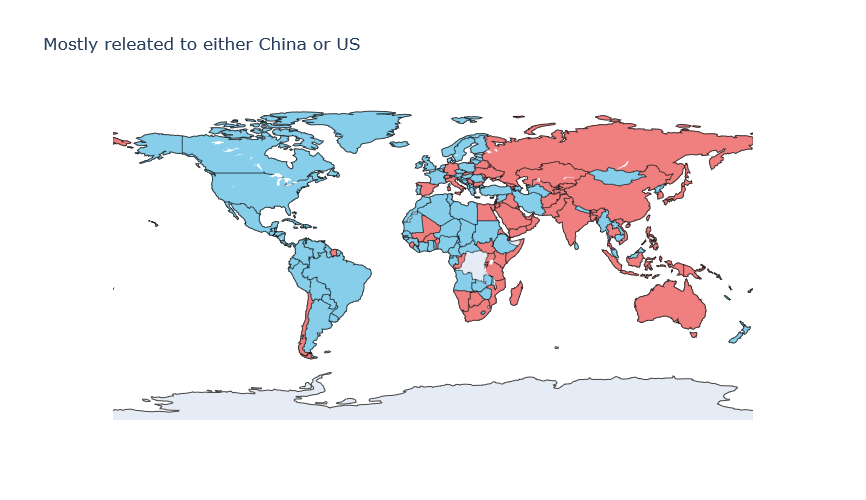

In [26]:
simrank_dict = nx.simrank_similarity(G)

simrank_plot(simrank_dict, type='Mostly releated to either China or US')

As we observe, the countries looks almost splitted in half, with the left part labeled as **US** and the right part as **China**; this behaviour is expected, since probably closer countries tend to trade with closer neighbours, leading the algorithm to split them territorially. 

# HO FATTO FINO A QUI. L'IDEA ORA SAREBBE DI VERIFICARE SE EFFETTIVAMENTE I PAESI COMMERCIANO CON I LORO VICINI. SI DOVREBBE POTER SPIEGARE CON IL LOCAL CLUSTERING COEFFICIENT.

## Local Clustering coefficient

The clustering coefficient measures the degree to which nodes in a graph tend to cluster together. In trade networks, it indicates the extent to which countries tend to form trade blocs or regional trade agreements. A higher clustering coefficient suggests that countries tend to trade more with their neighbors, forming tightly-knit clusters.

In [50]:
print(data['Uruguay'])

{'Coordinates': {'lat': -33.0, 'lon': -56.0}, 'Government type': 'Presidential Republic', 'GDP': '$83.607 billion', 'GDP% Exports': '21.6', 'GDP% Imports': '-18.4', 'Exports $': '$22.565 billion', 'Export Partners': {'China': '29', 'Brazil': '12', 'United States': '5', 'Netherlands': '5', 'Argentina': '5'}, 'Export Commodities': 'sulfate wood pulp, beef, soybeans, concentrated milk, rice', 'Imports $': '$18.894 billion', 'Import Partners': {'Brazil': '25', 'China': '15', 'United States': '11', 'Argentina': '11'}, 'Import Commodities': 'crude petroleum, packaged medicines, cars, broadcasting equipment, delivery trucks'}


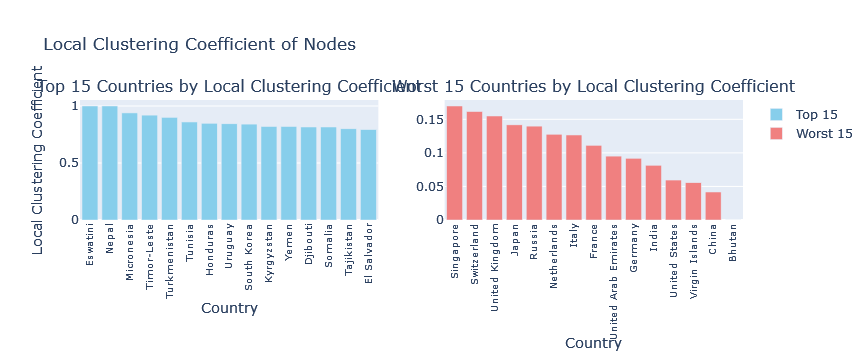

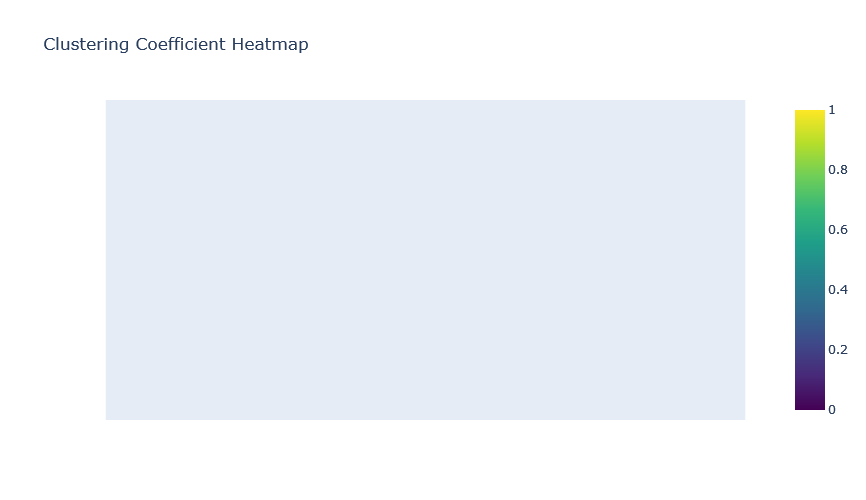

In [51]:
clustering_coeffs = nx.clustering(G)

high_clustering_nodes = histograms(clustering_coeffs, type='Local Clustering Coefficient', n=15, color='skyblue')
heatmap(clustering_coeffs, type='Clustering Coefficient')

### Correlation between Local Clustering Coefficient and Degree Centrality

Is a measure of how these two properties are related across the nodes of a graph. Degree centrality measures the number of connections a node has, while the local clustering coefficient measures the tendency of a node's neighbors to be connected with each other. By examining their correlation, we can gain insights into the structural properties of the graph.

Key Metrics:

-Local Clustering Coefficient (LCC): Indicates how likely a country's trade partners are to trade with each other.

-Degree Centrality (DC): Represents the number of direct trade connections a country has.

Pearson correlation coefficient: -0.5127
P-value: 2.8277e-15


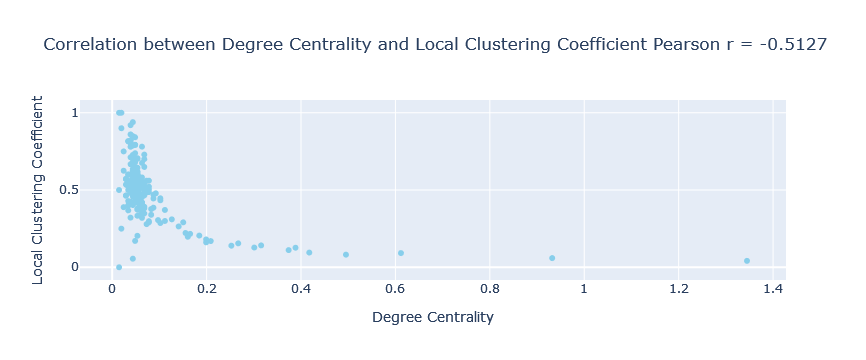

In [52]:
correlation, p_value = correlation_cd(clustering_coeffs, degree_centrality, color='skyblue')

## Small-World Effect

In [53]:
clustering_coefficient = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {clustering_coefficient:.4f}")
avg_shortest_path_length = avg_shortestpath(G)

Average Clustering Coefficient: 0.5027
Average Shortest Path Length: 2.2729


In [54]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
random_graph = nx.gnm_random_graph(num_nodes, num_edges, directed=True)

random_clustering_coefficient = nx.average_clustering(random_graph)
print(f"Random Graph Average Clustering Coefficient: {random_clustering_coefficient:.4f}")
random_avg_shortest_path_length = avg_shortestpath(random_graph)

Random Graph Average Clustering Coefficient: 0.0411
Average Shortest Path Length: 2.7213


In [55]:
print(f"Clustering Coefficient (G): {clustering_coefficient:.4f} vs. Random Graph: {random_clustering_coefficient:.4f}")
print(f"Average Shortest Path Length (G): {avg_shortest_path_length:.4f} vs. Random Graph: {random_avg_shortest_path_length:.4f}")

Clustering Coefficient (G): 0.5027 vs. Random Graph: 0.0411
Average Shortest Path Length (G): 2.2729 vs. Random Graph: 2.7213


## K-core and core periphery structures

K-core decomposition is used to identify subgraphs within the network that are more densely connected. The k-core of a graph is a maximal subgraph in which each node has at least degree k. By analyzing k-cores, we can identify the most influential and interconnected nodes within the trade network. These core nodes are crucial for understanding the backbone of the trade network, as they often represent countries with strong and diverse trade relationships.

In [59]:
core, highest_core = kcores(G, 3, 20)


Nodes in the 3-core (207 elements): ['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Gu

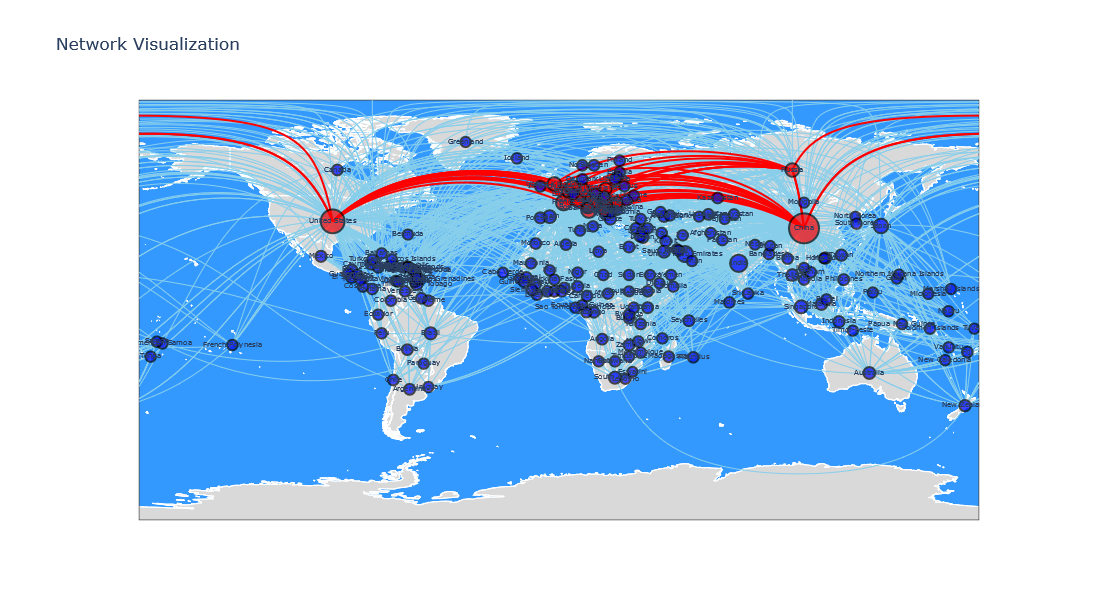

In [60]:
plot_network_on_world_map(G, degree_centrality, cliques=highest_core)

## Assortative mixing by degree

Assortative mixing by degree measures the tendency of nodes to connect to other nodes that are similar in degree. In the context of trade networks, this can indicate whether countries with similar trade volumes tend to trade with each other. High assortative mixing suggests that countries with high trade volumes (high-degree nodes) tend to trade more with other high-volume countries, while low assortative mixing might indicate a more diverse set of trade partners irrespective of trade volume.

In [61]:
assortativity_coefficient = nx.degree_assortativity_coefficient(G)

print(f"Assortative Mixing by Degree: {assortativity_coefficient:.4f}")

Assortative Mixing by Degree: -0.2991


### Visualize the degree correlations

Degree correlation measures the relationship between a node's degree and the average degree of its neighbors. This can help in understanding how nodes are connected within the network. In trade networks, it helps to analyze whether countries with many trade connections (high-degree nodes) tend to be connected to other well-connected countries or to less connected countries. This information can reveal the structural properties of the trade network, such as the presence of hubs or clusters.

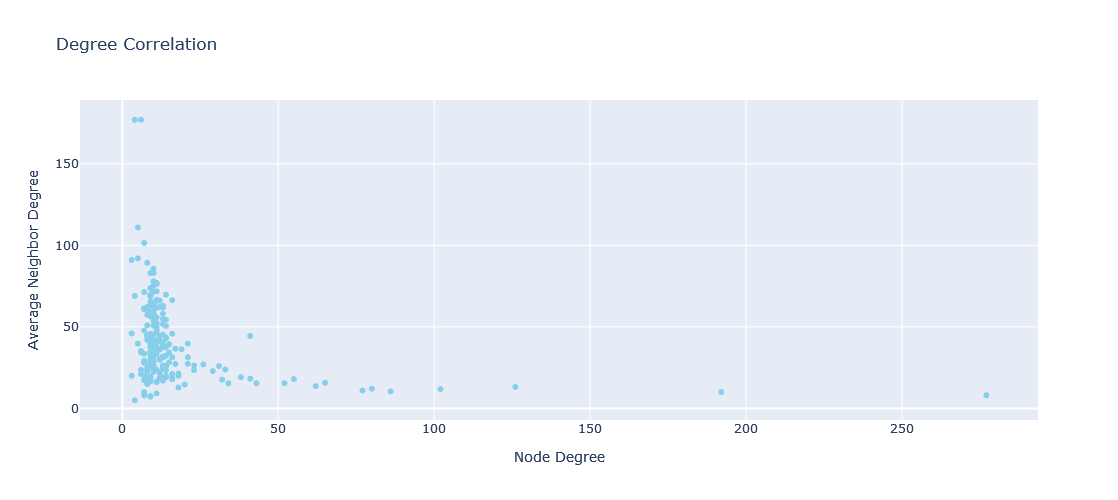

In [62]:
deg_cor(G)

## Density

Graph density is a measure of how many edges are present in the graph compared to the maximum possible number of edges. It gives a sense of how "dense" or "sparse" the network is. In the context of trade networks, density indicates the overall connectivity among countries. A denser network suggests that there are more trade relationships between countries, indicating a more interconnected and potentially robust global trade system.

In [63]:
graph_density = nx.density(G)

print(f"Graph Density: {graph_density:.4f}")

Graph Density: 0.0413


# Attributes Analysis and Comparisons

In [64]:
# Extracting data for histograms
gdp_data = extract_node_attributes(G, 'GDP')
exports_dollars_data = extract_node_attributes(G, 'Exports $')
imports_dollars_data = extract_node_attributes(G, 'Imports $')
exports_gdp_percentage_data = extract_node_attributes(G, 'Exports GDP%')
imports_gdp_percentage_data = extract_node_attributes(G, 'Imports GDP%')

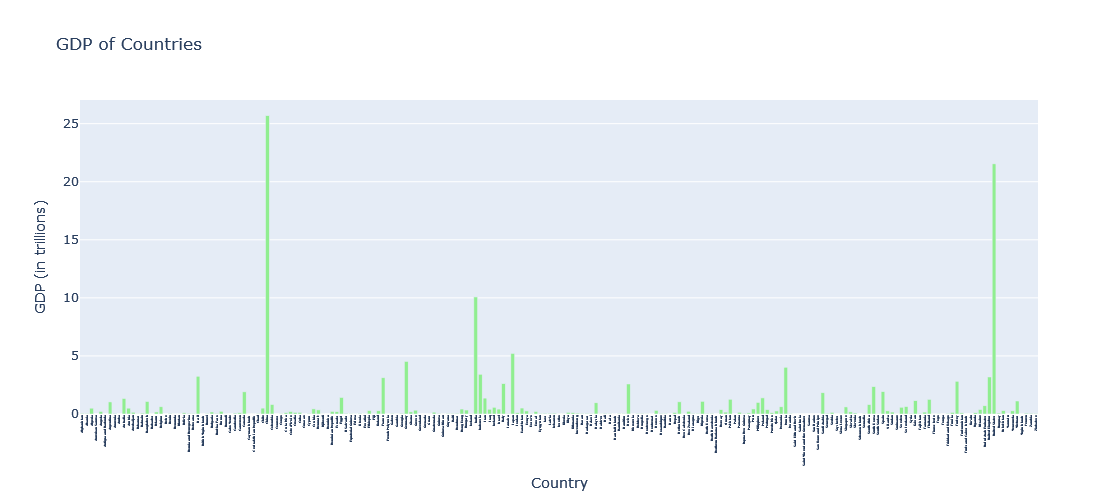

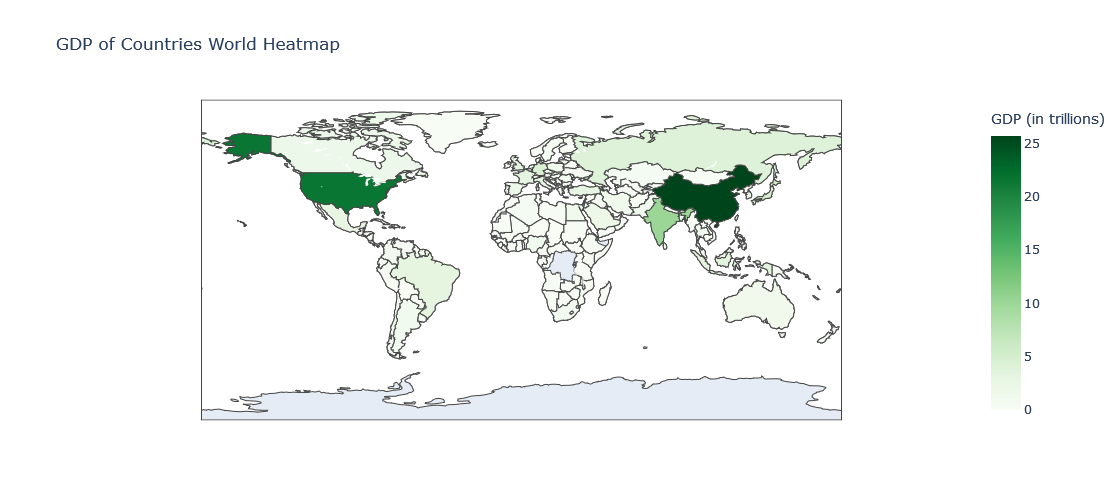

In [66]:
plot_attributes(gdp_data, 'GDP of Countries', 'Country', 'GDP (in trillions)', 'lightgreen','greens')

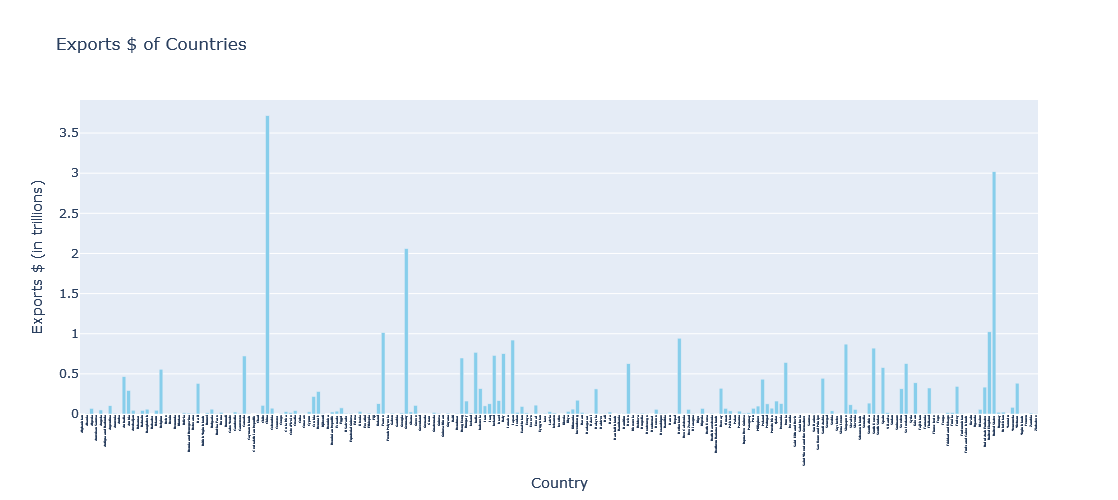

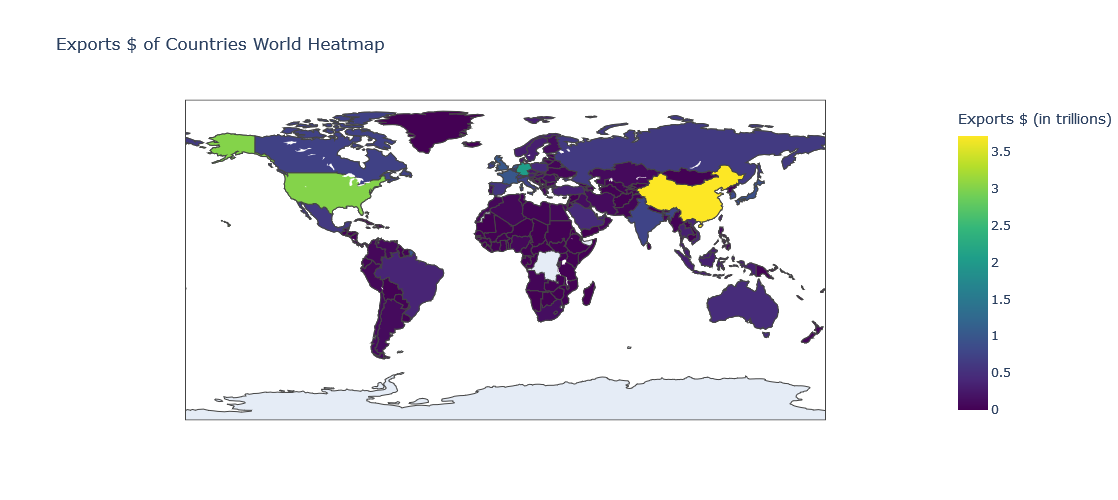

In [67]:
plot_attributes(exports_dollars_data, 'Exports $ of Countries', 'Country', 'Exports $ (in trillions)')

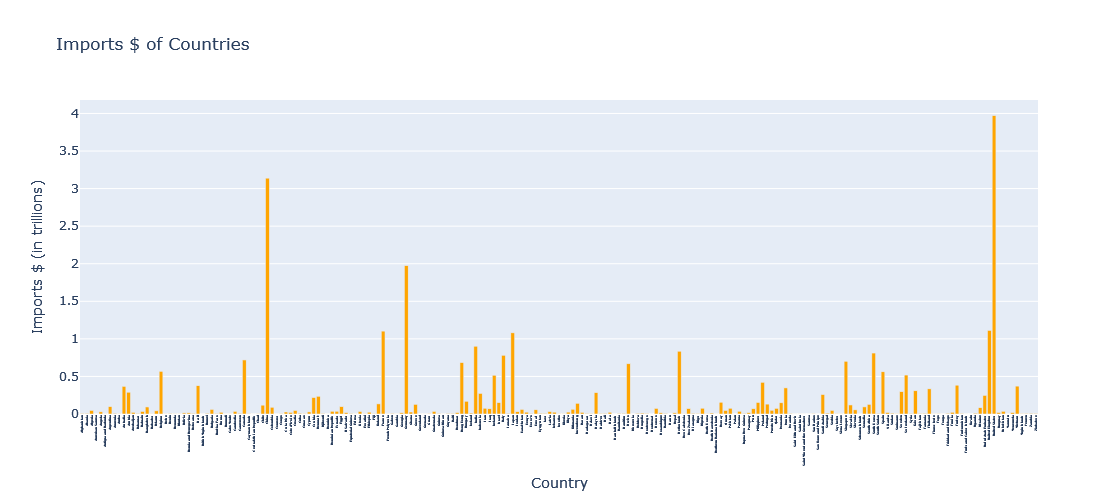

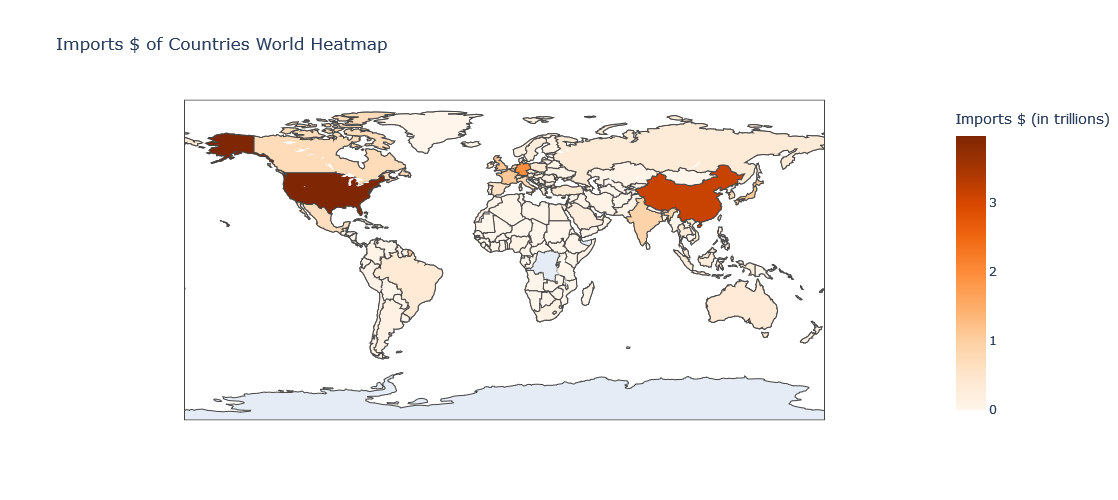

In [68]:
plot_attributes(imports_dollars_data, 'Imports $ of Countries', 'Country', 'Imports $ (in trillions)', 'orange', 'oranges')

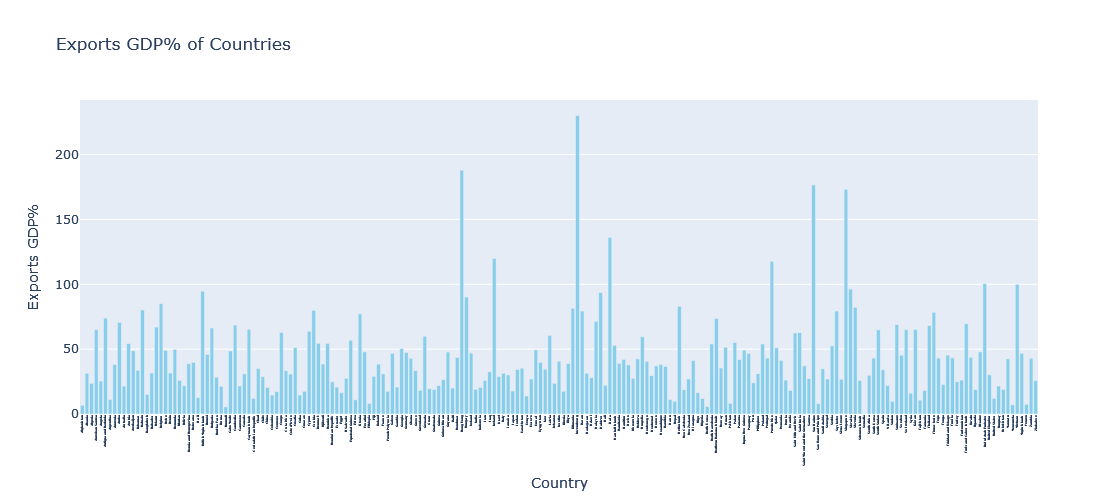

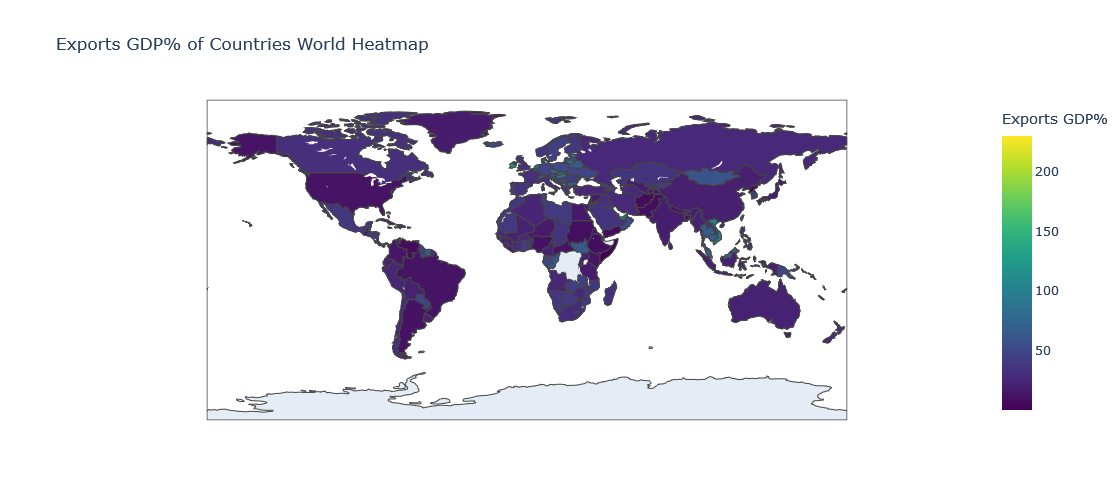

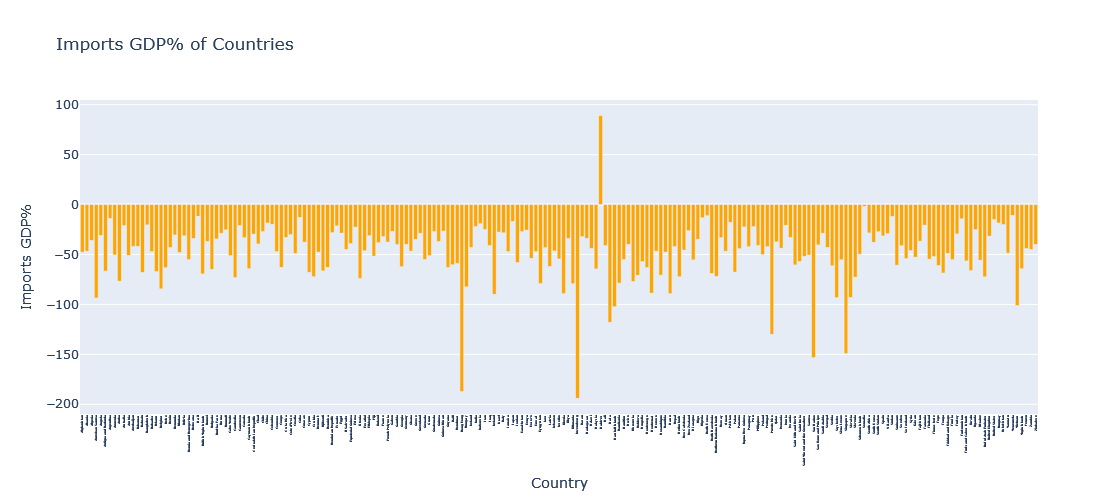

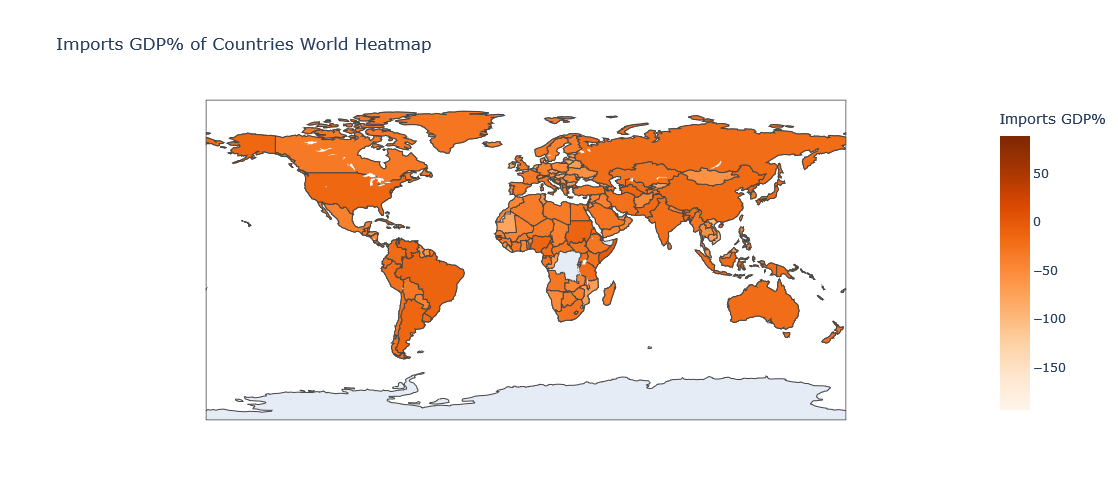

In [69]:
exports_gdp_percentage_data = {k: float(v) for k, v in exports_gdp_percentage_data.items()}
imports_gdp_percentage_data = {k: float(v) for k, v in imports_gdp_percentage_data.items()}
plot_attributes(exports_gdp_percentage_data, 'Exports GDP% of Countries', 'Country', 'Exports GDP%', 'skyblue')
plot_attributes(imports_gdp_percentage_data, 'Imports GDP% of Countries', 'Country', 'Imports GDP%', 'orange', 'oranges')

## Commodities

In [80]:
commodity_counts_export, commodity_counts_import = analyze_commodities(node_attributes)
print(commodity_counts_export.most_common(20))

[('refined petroleum', 80), ('gold', 65), ('crude petroleum', 46), ('natural gas', 36), ('packaged medicines', 30), ('lumber', 22), ('copper', 18), ('cars and vehicle parts', 18), ('integrated circuits', 18), ('insulated wiring', 17), ('diamonds', 15), ('broadcasting equipment', 15), ('scrap iron', 14), ('iron alloys', 13), ('ships', 13), ('cars', 13), ('tuna', 13), ('clothing and apparel', 13), ('electricity', 11), ('fertilizers', 11)]


In [81]:
print(commodity_counts_import.most_common(20))

[('refined petroleum', 161), ('cars', 118), ('packaged medicines', 81), ('broadcasting equipment', 70), ('crude petroleum', 53), ('natural gas', 36), ('delivery trucks', 30), ('rice', 27), ('aircraft', 22), ('gold', 19), ('cars and vehicle parts', 19), ('ships', 18), ('jewelry', 15), ('wheat', 14), ('electricity', 13), ('integrated circuits', 13), ('clothing and apparel', 13), ('recreational boats', 10), ('iron', 10), ('palm oil', 9)]


### Common Commodities Between Countries and Commodity Frequency

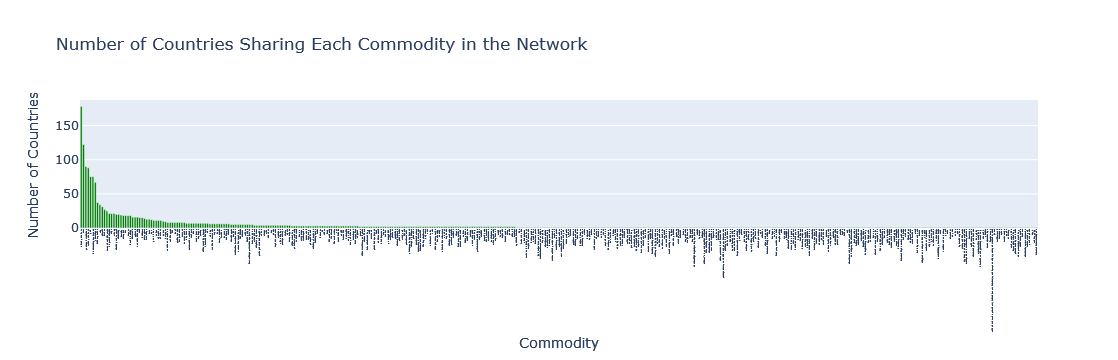

Commodity 'wheat flours' is shared by countries: Afghanistan, Saint Vincent and the Grenadines, Lesotho, Syria
Commodity 'cotton' is shared by countries: Afghanistan, Greece, Azerbaijan, Bangladesh, Benin, Togo, Burkina Faso, Mali, Sudan, Tajikistan
Commodity 'gold' is shared by countries: Afghanistan, United Arab Emirates, India, China, Uzbekistan, Turkey, United Kingdom, Australia, Ghana, Fiji, Singapore, South Africa, Suriname, Argentina, Armenia, Switzerland, Iraq, Malaysia, Jordan, Venezuela, Thailand, Azerbaijan, Bahrain, Saudi Arabia, Guyana, Benin, Canada, Bolivia, Peru, Colombia, Botswana, Hong Kong, Namibia, Burkina Faso, Burundi, Tanzania, Zambia, Cambodia, Cameroon, Cayman Islands, Central African Republic, Chad, Madagascar, Rwanda, Libya, Egypt, Dominican Republic, Honduras, Nicaragua, Eritrea, Eswatini, Ethiopia, Mali, Senegal, Guinea, Kazakhstan, Uganda, Kyrgyzstan, Laos, Lebanon, Liberia, Malawi, Mauritania, Mongolia, Mozambique, Niger, Oman, Papua New Guinea, Solomon I

In [121]:
commodity_to_countries, commodity_to_countries_export, commodity_to_countries_import = find_countries_with_common_commodities(G)

plot_common_commodities_histogram(commodity_to_countries, color='green')
print_common_commodities(commodity_to_countries)

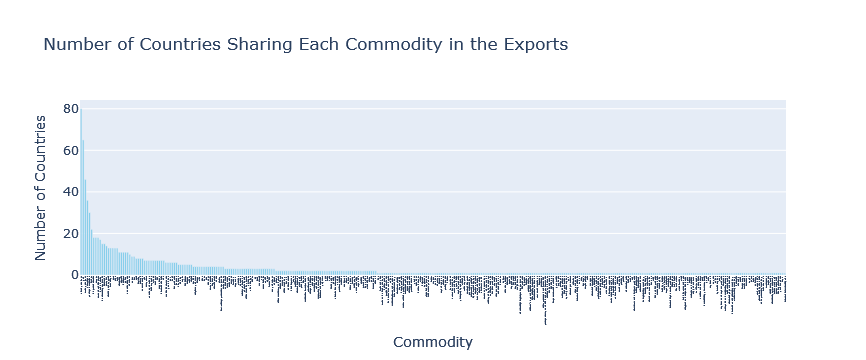

Commodity 'gold' is shared by countries: Afghanistan, United Arab Emirates, Uzbekistan, United Kingdom, Australia, Ghana, Fiji, Singapore, South Africa, Suriname, Argentina, Armenia, Switzerland, Iraq, Venezuela, Azerbaijan, Guyana, Benin, Canada, Bolivia, Peru, Colombia, Botswana, Hong Kong, Namibia, Burkina Faso, Burundi, Tanzania, Zambia, Cameroon, Cayman Islands, Central African Republic, Chad, Madagascar, Rwanda, Libya, Egypt, Dominican Republic, Honduras, Nicaragua, Eritrea, Eswatini, Ethiopia, Mali, Senegal, Guinea, Kazakhstan, Uganda, Kyrgyzstan, Laos, Lebanon, Liberia, Malawi, Mauritania, Mongolia, Mozambique, Niger, Papua New Guinea, Solomon Islands, Somalia, South Sudan, Sudan, Tajikistan, Yemen, Zimbabwe
Commodity 'grapes' is shared by countries: Afghanistan, Lebanon
Commodity 'cotton' is shared by countries: Afghanistan, Greece, Azerbaijan, Benin, Togo, Burkina Faso, Mali, Sudan, Tajikistan
Commodity 'coal' is shared by countries: Afghanistan, Australia, Indonesia, South A

In [123]:
plot_common_commodities_histogram(commodity_to_countries_export, name='Exports')
print_common_commodities(commodity_to_countries_export)

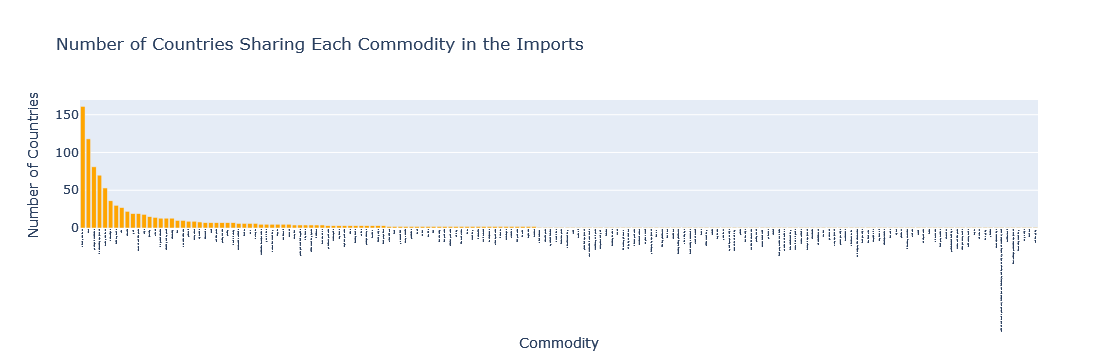

Commodity 'wheat flours' is shared by countries: Afghanistan, Syria
Commodity 'broadcasting equipment' is shared by countries: Afghanistan, United Arab Emirates, Germany, United States, Australia, Burma, Fiji, New Zealand, Kenya, South Africa, Poland, Chile, Armenia, Russia, Iraq, Netherlands, Iran, Jordan, Japan, Austria, Czechia, Israel, Bahrain, Saudi Arabia, Belarus, Ukraine, Togo, Luxembourg, Peru, Colombia, Hong Kong, Romania, Central African Republic, Chad, Rwanda, Costa Rica, Hungary, Libya, Slovakia, Denmark, Sweden, Norway, El Salvador, Honduras, Estonia, Finland, Latvia, Lithuania, Tonga, French Polynesia, Mali, Guam, Philippines, Kazakhstan, Kuwait, Kyrgyzstan, Maldives, Micronesia, Moldova, Montserrat, Nepal, Oman, Palau, Paraguay, Qatar, Somalia, Syria, Turkmenistan, Uruguay, Vanuatu
Commodity 'refined petroleum' is shared by countries: Afghanistan, United Arab Emirates, Pakistan, Uzbekistan, Albania, Italy, Spain, Greece, France, Turkey, Algeria, South Korea, Australia, 

In [125]:
plot_common_commodities_histogram(commodity_to_countries_import, name='Imports', color='orange')
print_common_commodities(commodity_to_countries_import)

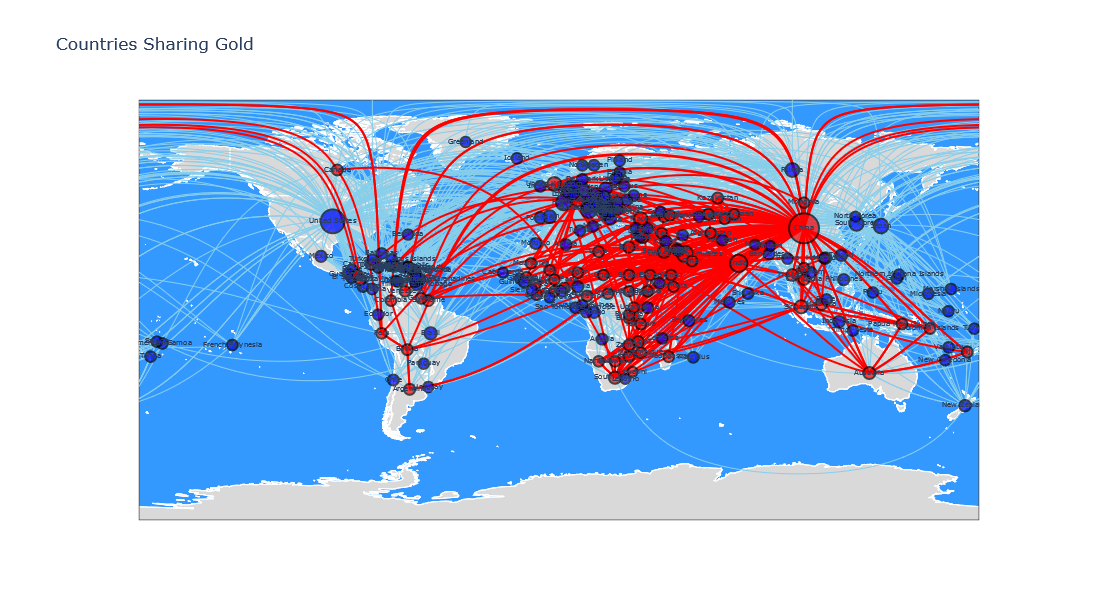

In [127]:
plot_commodity_on_world_map(G, degree_centrality, 'gold', title='Countries Sharing Gold')